In [1]:
!pip install -q transformers accelerate bitsandbytes scipy

In [2]:
from huggingface_hub import notebook_login
notebook_login()

In [3]:
import torch
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [5]:
data = pd.read_csv('../../../data/yelp/test_en_parallel.txt', sep='\t', header=None, skiprows=1)
data.columns = ['NEG', 'POS']

In [6]:
neg_sentences = data['NEG'].values
pos_sentences = data['POS'].values

In [7]:
sentences = list(neg_sentences) + list(pos_sentences)
labels = [0] * len(neg_sentences) + [1] * len(pos_sentences)

df = pd.DataFrame({'sentence': sentences, 'label': labels})
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Number of samples {len(df)}")
print(f"Negative: {sum(df['label'] == 0)}, Positive: {sum(df['label'] == 1)}")
print(f"\nSome samples:")
print(df.head(10))

Number of samples 2000
Negative: 1000, Positive: 1000

Some samples:
                                            sentence  label
0  place was clean and well kept, drinks were rea...      1
1  it didn't matter of she is good at all other t...      0
2          Everything was hot including the coffee.       1
3                         won't go back with friends      0
4                this place is beyond a great place.      1
5             Very great time here for the 2nd time.      1
6                    worst take out or eat in sushi!      0
7  ordered the huevos rancheros and it was delici...      1
8    you'll have zero appetite after the first bite.      0
9  no wonder these restaurants aren't closing up ...      1


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    df['sentence'].values,
    df['label'].values,
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

print(f"\nTrain: {len(X_train)}, Test: {len(X_test)}")


Train: 1600, Test: 400


In [9]:
model_name = 'meta-llama/Llama-2-7b-chat-hf'

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_use_double_quant=True
)

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map='auto',
    trust_remote_code=True
)

model.eval()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRMS

In [10]:
np.random.seed(42)

def create_few_shot_prompt(test_sentence, n_shots, train_sentences, train_labels):
    if n_shots == 0:
        prompt = f"""Classify the sentiment of the following sentence as either 'POSITIVE' or 'NEGATIVE'.
Only respond with one word: POSITIVE or NEGATIVE.

Sentence: {test_sentence}
Sentiment:"""
    else:
        prompt = "Classify the sentiment of sentences as either 'POSITIVE' or 'NEGATIVE'.\n\n"

        neg_indices = [i for i, l in enumerate(train_labels) if l == 0]
        pos_indices = [i for i, l in enumerate(train_labels) if l == 1]

        n_per_class = n_shots // 2

        selected_neg = np.random.choice(neg_indices, min(n_per_class, len(neg_indices)), replace=False)
        selected_pos = np.random.choice(pos_indices, min(n_per_class, len(pos_indices)), replace=False)

        selected_indices = list(selected_neg) + list(selected_pos)
        np.random.shuffle(selected_indices)

        for idx in selected_indices:
            sentiment = "POSITIVE" if train_labels[idx] == 1 else "NEGATIVE"
            prompt += f"Sentence: {train_sentences[idx]}\nSentiment: {sentiment}\n\n"

        prompt += f"Sentence: {test_sentence}\nSentiment:"

    return prompt

In [11]:
def predict_sentiment(prompt, max_new_tokens=5):
    inputs = tokenizer(
        prompt,
        return_tensors='pt',
        truncation=True,
        max_length=2048).to(device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=0.1,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id
        )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    response = response.split("Sentiment:")[-1].strip().upper()

    if 'POSITIVE' in response:
        return 1
    elif 'NEGATIVE' in response:
        return 0
    else:
        return 1 if 'GOOD' in response or 'GREAT' in response else 0


In [13]:
n_shot_values = [0, 1, 5, 10]
results = []

In [15]:
for n_shots in n_shot_values:
    print(f"n={n_shots}")
    np.random.seed(42)

    predictions = []

    for i, test_sentence in enumerate(tqdm(X_test, desc=f"{n_shots}-shot")):
        prompt = create_few_shot_prompt(test_sentence, n_shots, X_train, y_train)
        pred = predict_sentiment(prompt)
        predictions.append(pred)

        if i % 50 == 0:
            print(f"\nSample {i}:")
            print(f"Sentence: {test_sentence[:60]}")
            print(f"Predicted: {'POSITIVE' if pred == 1 else 'NEGATIVE'}")
            print(f"Actual: {'POSITIVE' if y_test[i] == 1 else 'NEGATIVE'}")

    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, zero_division=0)
    recall = recall_score(y_test, predictions, zero_division=0)
    f1 = f1_score(y_test, predictions, zero_division=0)

    results.append({
        'n_shots': n_shots,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })

    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"Percision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1: {f1:.4f}")

n=0


0-shot:   0%|          | 1/400 [00:00<04:48,  1.38it/s]


Sample 0:
Sentence: not that great after the river
Predicted: NEGATIVE
Actual: NEGATIVE


0-shot:  13%|█▎        | 51/400 [00:22<02:43,  2.14it/s]


Sample 50:
Sentence: it was a little overcooked
Predicted: NEGATIVE
Actual: POSITIVE


0-shot:  25%|██▌       | 101/400 [00:45<02:03,  2.41it/s]


Sample 100:
Sentence: the brunch was bad, with little selection
Predicted: NEGATIVE
Actual: NEGATIVE


0-shot:  38%|███▊      | 151/400 [01:08<01:48,  2.30it/s]


Sample 150:
Sentence: i said it was disgusting to even serve this to diners.
Predicted: NEGATIVE
Actual: NEGATIVE


0-shot:  50%|█████     | 201/400 [01:32<01:32,  2.16it/s]


Sample 200:
Sentence: it is a cool place, with lots to see and try.
Predicted: POSITIVE
Actual: POSITIVE


0-shot:  63%|██████▎   | 251/400 [01:55<01:11,  2.08it/s]


Sample 250:
Sentence: and every experience has been a positive one.
Predicted: POSITIVE
Actual: POSITIVE


0-shot:  75%|███████▌  | 301/400 [02:18<00:41,  2.40it/s]


Sample 300:
Sentence: tzatziki sauce had way too much dill in it.
Predicted: NEGATIVE
Actual: NEGATIVE


0-shot:  88%|████████▊ | 351/400 [02:38<00:15,  3.08it/s]


Sample 350:
Sentence: suzanne and her staff were horrible
Predicted: NEGATIVE
Actual: NEGATIVE


0-shot: 100%|██████████| 400/400 [03:00<00:00,  2.22it/s]



Accuracy: 0.7500
Percision: 0.9630
Recall: 0.5200
F1: 0.6753
n=1


1-shot:   0%|          | 1/400 [00:00<03:18,  2.01it/s]


Sample 0:
Sentence: not that great after the river
Predicted: NEGATIVE
Actual: NEGATIVE


1-shot:  13%|█▎        | 51/400 [00:22<03:00,  1.94it/s]


Sample 50:
Sentence: it was a little overcooked
Predicted: NEGATIVE
Actual: POSITIVE


1-shot:  25%|██▌       | 101/400 [00:45<02:19,  2.14it/s]


Sample 100:
Sentence: the brunch was bad, with little selection
Predicted: NEGATIVE
Actual: NEGATIVE


1-shot:  38%|███▊      | 151/400 [01:08<02:08,  1.94it/s]


Sample 150:
Sentence: i said it was disgusting to even serve this to diners.
Predicted: NEGATIVE
Actual: NEGATIVE


1-shot:  50%|█████     | 201/400 [01:32<01:34,  2.11it/s]


Sample 200:
Sentence: it is a cool place, with lots to see and try.
Predicted: POSITIVE
Actual: POSITIVE


1-shot:  63%|██████▎   | 251/400 [01:55<01:07,  2.22it/s]


Sample 250:
Sentence: and every experience has been a positive one.
Predicted: POSITIVE
Actual: POSITIVE


1-shot:  75%|███████▌  | 301/400 [02:18<00:40,  2.46it/s]


Sample 300:
Sentence: tzatziki sauce had way too much dill in it.
Predicted: NEGATIVE
Actual: NEGATIVE


1-shot:  88%|████████▊ | 351/400 [02:40<00:23,  2.12it/s]


Sample 350:
Sentence: suzanne and her staff were horrible
Predicted: NEGATIVE
Actual: NEGATIVE


1-shot: 100%|██████████| 400/400 [03:03<00:00,  2.17it/s]



Accuracy: 0.9025
Percision: 0.8710
Recall: 0.9450
F1: 0.9065
n=5


5-shot:   0%|          | 1/400 [00:00<03:12,  2.08it/s]


Sample 0:
Sentence: not that great after the river
Predicted: NEGATIVE
Actual: NEGATIVE


5-shot:  13%|█▎        | 51/400 [00:21<02:27,  2.36it/s]


Sample 50:
Sentence: it was a little overcooked
Predicted: NEGATIVE
Actual: POSITIVE


5-shot:  25%|██▌       | 101/400 [00:43<02:07,  2.35it/s]


Sample 100:
Sentence: the brunch was bad, with little selection
Predicted: NEGATIVE
Actual: NEGATIVE


5-shot:  38%|███▊      | 151/400 [01:04<01:45,  2.37it/s]


Sample 150:
Sentence: i said it was disgusting to even serve this to diners.
Predicted: NEGATIVE
Actual: NEGATIVE


5-shot:  50%|█████     | 201/400 [01:25<01:22,  2.42it/s]


Sample 200:
Sentence: it is a cool place, with lots to see and try.
Predicted: POSITIVE
Actual: POSITIVE


5-shot:  63%|██████▎   | 251/400 [01:46<01:03,  2.34it/s]


Sample 250:
Sentence: and every experience has been a positive one.
Predicted: POSITIVE
Actual: POSITIVE


5-shot:  75%|███████▌  | 301/400 [02:07<00:41,  2.37it/s]


Sample 300:
Sentence: tzatziki sauce had way too much dill in it.
Predicted: NEGATIVE
Actual: NEGATIVE


5-shot:  88%|████████▊ | 351/400 [02:28<00:20,  2.40it/s]


Sample 350:
Sentence: suzanne and her staff were horrible
Predicted: NEGATIVE
Actual: NEGATIVE


5-shot: 100%|██████████| 400/400 [02:48<00:00,  2.37it/s]



Accuracy: 0.8925
Percision: 0.8792
Recall: 0.9100
F1: 0.8943
n=10


10-shot:   0%|          | 1/400 [00:00<03:16,  2.04it/s]


Sample 0:
Sentence: not that great after the river
Predicted: NEGATIVE
Actual: NEGATIVE


10-shot:  13%|█▎        | 51/400 [00:24<02:46,  2.10it/s]


Sample 50:
Sentence: it was a little overcooked
Predicted: NEGATIVE
Actual: POSITIVE


10-shot:  25%|██▌       | 101/400 [00:47<02:20,  2.12it/s]


Sample 100:
Sentence: the brunch was bad, with little selection
Predicted: NEGATIVE
Actual: NEGATIVE


10-shot:  38%|███▊      | 151/400 [01:11<01:56,  2.14it/s]


Sample 150:
Sentence: i said it was disgusting to even serve this to diners.
Predicted: NEGATIVE
Actual: NEGATIVE


10-shot:  50%|█████     | 201/400 [01:35<01:33,  2.12it/s]


Sample 200:
Sentence: it is a cool place, with lots to see and try.
Predicted: POSITIVE
Actual: POSITIVE


10-shot:  63%|██████▎   | 251/400 [01:59<01:11,  2.10it/s]


Sample 250:
Sentence: and every experience has been a positive one.
Predicted: POSITIVE
Actual: POSITIVE


10-shot:  75%|███████▌  | 301/400 [02:23<00:47,  2.07it/s]


Sample 300:
Sentence: tzatziki sauce had way too much dill in it.
Predicted: NEGATIVE
Actual: NEGATIVE


10-shot:  88%|████████▊ | 351/400 [02:46<00:24,  2.00it/s]


Sample 350:
Sentence: suzanne and her staff were horrible
Predicted: NEGATIVE
Actual: NEGATIVE


10-shot: 100%|██████████| 400/400 [03:10<00:00,  2.10it/s]


Accuracy: 0.8950
Percision: 0.8798
Recall: 0.9150
F1: 0.8971


In [16]:
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

 n_shots  accuracy  precision  recall       f1
       0    0.7500   0.962963   0.520 0.675325
       1    0.9025   0.870968   0.945 0.906475
       5    0.8925   0.879227   0.910 0.894349
      10    0.8950   0.879808   0.915 0.897059


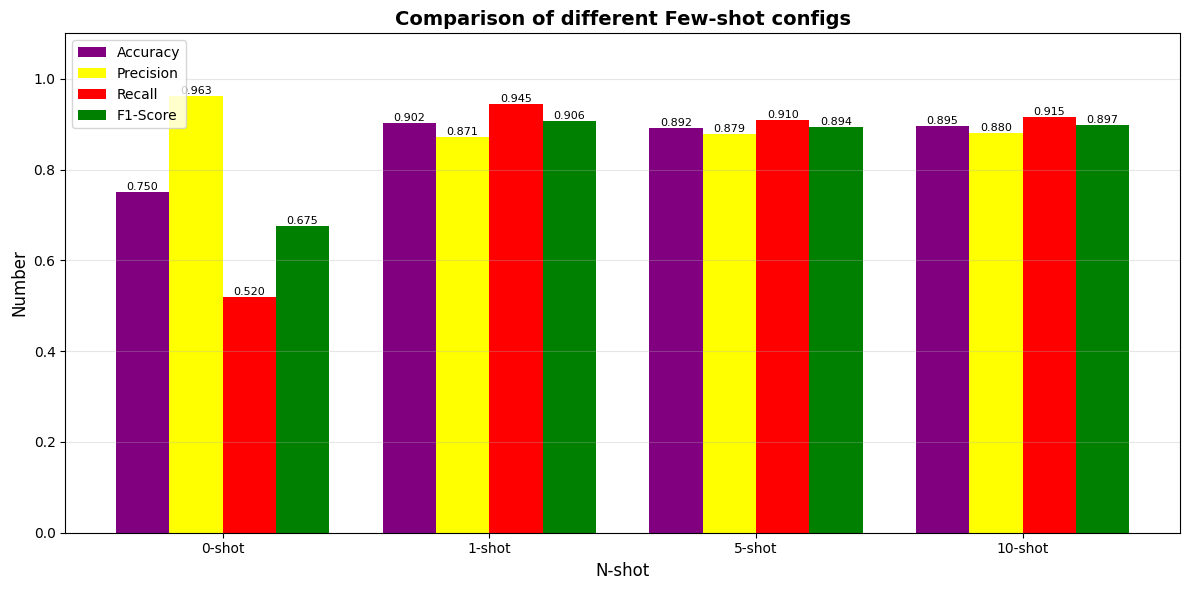

In [17]:
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(n_shot_values))
width = 0.2

bars1 = ax.bar(x - 1.5*width, results_df['accuracy'], width, label='Accuracy', color='purple')
bars2 = ax.bar(x - 0.5*width, results_df['precision'], width, label='Precision', color='yellow')
bars3 = ax.bar(x + 0.5*width, results_df['recall'], width, label='Recall', color='red')
bars4 = ax.bar(x + 1.5*width, results_df['f1'], width, label='F1-Score', color='green')

ax.set_xlabel('N-shot', fontsize=12)
ax.set_ylabel('Number', fontsize=12)
ax.set_title('Comparison of different Few-shot configs',
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f'{n}-shot' for n in n_shot_values])
ax.legend()
ax.grid(True, axis='y', alpha=0.3)
ax.set_ylim(0.0, 1.1)

for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

In [18]:
best_config = results_df.loc[results_df['f1'].idxmax()]
print(f"\nBest config: {int(best_config['n_shots'])}-shot")
print(f"F1-score: {best_config['f1']:.4f}")
print(f"Accuracy: {best_config['accuracy']:.4f}")


Best config: 1-shot
F1-score: 0.9065
Accuracy: 0.9025


In [28]:
all_results = {
    # Lab 1 (Traditional NLP + LSTM)
    'LSTM Baseline (Lab1)': {
        'accuracy': 0.9001,
        'precision': 0.9050,
        'recall': 0.9623,
        'f1': 0.9328,
    },

    # Lab 2 (Transformer models)
    'RoBERTa (Lab2)': {
        'accuracy': 0.9220,
        'precision': 0.9357,
        'recall': 0.9575,
        'f1': 0.9464,
    },
    'DistilBERT (Lab2)': {
        'accuracy': 0.9126,
        'precision': 0.9286,
        'recall': 0.9518,
        'f1': 0.9401,
    },

    # Lab 3 (Multi-task Learning)
    'T5 Multi-task (Lab3)': {
        'accuracy': 0.8911,
        'precision': None,
        'recall': None,
        'f1': None,
    },

    # Lab 4 (Few-shot Learning)
    'LLaMA-2 0-shot (Lab4)': {
        'accuracy': results[0]['accuracy'],
        'precision': results[0]['precision'],
        'recall': results[0]['recall'],
        'f1': results[0]['f1'],
    },
    'LLaMA-2 1-shot (Lab4)': {
        'accuracy': results[1]['accuracy'],
        'precision': results[1]['precision'],
        'recall': results[1]['recall'],
        'f1': results[1]['f1'],
    },
    'LLaMA-2 5-shot (Lab4)': {
        'accuracy': results[2]['accuracy'],
        'precision': results[2]['precision'],
        'recall': results[2]['recall'],
        'f1': results[2]['f1'],
    },
    'LLaMA-2 10-shot (Lab4)': {
        'accuracy': results[3]['accuracy'],
        'precision': results[3]['precision'],
        'recall': results[3]['recall'],
        'f1': results[3]['f1'],
    }
}

In [29]:
classification_models = {
    name: metrics for name, metrics in all_results.items()
    if metrics['f1'] is not None
}

In [30]:
df = pd.DataFrame([
    {
        'Model': name,
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1-Score': metrics['f1'],
    }
    for name, metrics in classification_models.items()
]).sort_values('F1-Score', ascending=False).reset_index(drop=True)

print(df.to_string(index=False))

                 Model  Accuracy  Precision  Recall  F1-Score
        RoBERTa (Lab2)    0.9220   0.935700  0.9575  0.946400
     DistilBERT (Lab2)    0.9126   0.928600  0.9518  0.940100
  LSTM Baseline (Lab1)    0.9001   0.905000  0.9623  0.932800
 LLaMA-2 1-shot (Lab4)    0.9025   0.870968  0.9450  0.906475
LLaMA-2 10-shot (Lab4)    0.8950   0.879808  0.9150  0.897059
 LLaMA-2 5-shot (Lab4)    0.8925   0.879227  0.9100  0.894349
 LLaMA-2 0-shot (Lab4)    0.7500   0.962963  0.5200  0.675325


##### Conclusion:

The results show that supervised transformer-based models from the previous laboratory exercises (RoBERTa and DistilBERT) still achieve the best overall performance in sentiment classification, benefiting from task-specific fine-tuning on labeled data. The experiments in this laboratory show that LLaMA-2, despite not being trained for the task, is capable of achieving competitive results using only few-shot prompting. In particular, the 1-shot configuration achieves over 90% accuracy and F1-score, approaching the performance of fine-tuned models. The 0-shot setup scores high precision but low recall, indicating conservative predictions. Finally, increasing the number of examples by more than one does not further improve performance, implying prompt saturation.